In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
drive_prefix = '/content/drive/My Drive/'

Mounted at /content/drive


In [2]:
# import libraries
import nltk
from nltk.parse import DependencyGraph
from nltk.tokenize import RegexpTokenizer
from nltk.collocations import *
!pip install pymorphy2[fast]
from pymorphy2 import MorphAnalyzer
from collections import Counter
import os
import re
import numpy as np
from nltk.metrics.spearman import *
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

1. Скачайте корпус текстов, обработайте его с помощью UDPipe, извлеките все группы "глагол + прямое дополнение, выраженное существительным" (не учитывайте глаголы, которые встречаются в корпусе менее 50 раз).

In [0]:
with open(os.path.join(drive_prefix, 'testset2.txt'), 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
!chmod 777 /content/drive/My\ Drive/udpipe/bin-linux64/udpipe
!/content/drive/My\ Drive/udpipe/bin-linux64/udpipe --input horizontal --output conllu \
--tokenize --tag --parse \
/content/drive/My\ Drive/russian-syntagrus.udpipe \
< /content/drive/My\ Drive/testset2.txt > /content/drive/My\ Drive/testset2.conllu

Loading UDPipe model: done.


In [0]:
trees = []

with open(os.path.join(drive_prefix, 'testset2.conllu'), 'r', encoding='utf-8') as f:
    parsed_sents = f.read().split('\n\n')

    for sent in parsed_sents:
        tree = [line for line in sent.split('\n') if line and line[0] != '#']
        trees.append('\n'.join(tree))

In [0]:
m = MorphAnalyzer()
tokenizer = RegexpTokenizer(r'\w+')

In [0]:
def normalize(text):
    tokens = tokenizer.tokenize(text.lower())
    lemmas = [m.parse(token)[0].normal_form for token in tokens]
    return lemmas

In [0]:
lemmas = normalize(text)

In [0]:
lemma_counter = Counter(lemmas)

In [0]:
def get_full_sentence(tree):
    return ' '.join(line.split('\t')[1] for line in tree.split('\n'))

In [11]:
vp_list = set()
for tree in trees:
    try:
        g = DependencyGraph(tree, top_relation_label='root')
    except AssertionError:
        # The problem seems to be with e.g. "40 000" parsed as one token
        print(f'AssertionError happened in nltk inner code on the following sentence: {get_full_sentence(tree)}')
        continue
    for v in g.nodes:
        if g.nodes[v]['ctag'] == 'VERB' and 'obj' in g.nodes[v]['deps'] and lemma_counter[g.nodes[v]['lemma'].lower()] >= 50:
            for obj in g.nodes[v]['deps']['obj']:
                if g.nodes[obj]['ctag'] == 'NOUN' and g.nodes[obj]['rel'] == 'obj':
                    vp_list.add((g.nodes[v]['lemma'].lower(), g.nodes[obj]['lemma'].lower()))
vp_list = list(vp_list)

AssertionError happened in nltk inner code on the following sentence: 15 ноября поиску Росздравнадзора компания была оштрафована на 40 000 руб . 159 ( мошенничество в крупном размере ) УК РФ , — сообщила адвокат . —
AssertionError happened in nltk inner code on the following sentence: В ходе следствия было доказано , что Мавроди нанес ущерб на сумму примерно в 110 млн руб . свыше 10 000 потерпевшим , но большинство из них исков не подавали .
AssertionError happened in nltk inner code on the following sentence: В ответ менеджмент Ford предложил им повышение зарплат на 14 – 20 % , один дополнительный выходной к ежегодному отпуску и выплату по 10 000 руб . всем , кто проработал на конвейере более пяти лет .
AssertionError happened in nltk inner code on the following sentence: В тексте жалобы , который есть у " Ведомостей " , налоговики требуют признать недействительным договор между двумя компаниями и взыскать в доход государства $ 145 000 , которые ЮКОС заплатил за аудит бухгалтерской от

2. Оцените полученные словосочетания следующими метриками: log-likelihood, dice, PMI (можно использовать nltk.collocations).

In [0]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(lemmas)
# added bigram frequency filter
finder.apply_freq_filter(5)

In [0]:
likelihood_dct = dict(finder.score_ngrams(bigram_measures.likelihood_ratio))
likelihood_values = {vp: likelihood_dct[vp] if vp in likelihood_dct else -np.inf for vp in vp_list}

In [14]:
sorted(likelihood_values.items(), key=lambda x: x[1], reverse=True)[:20]

[(('подать', 'иск'), 387.1438873886019),
 (('удовлетворить', 'иск'), 377.6583419074894),
 (('представлять', 'интерес'), 297.3521133267335),
 (('принять', 'решение'), 295.9808220095109),
 (('выдать', 'санкция'), 269.9398996288046),
 (('вынести', 'решение'), 249.45326927567072),
 (('удовлетворить', 'ходатайство'), 228.56414080178342),
 (('обжаловать', 'решение'), 198.48300200438945),
 (('иметь', 'право'), 188.99486868051574),
 (('вынести', 'приговор'), 139.74755462972476),
 (('предъявить', 'обвинение'), 126.78925072610392),
 (('подать', 'апелляция'), 116.14125005005982),
 (('рассмотреть', 'жалоба'), 115.42097678949956),
 (('отклонить', 'иск'), 109.6079211501184),
 (('признать', 'правота'), 96.28722585810247),
 (('отменить', 'решение'), 89.75510293744162),
 (('отклонить', 'жалоба'), 83.38273625071997),
 (('подтвердить', 'законность'), 80.06330379242267),
 (('отменить', 'постановление'), 75.08096782665386),
 (('просить', 'суд'), 72.33345507889857)]

In [0]:
likelihood_top_100 = [elem[0] for elem in sorted(likelihood_values.items(), key=lambda x: x[1], reverse=True)[:100]]

In [0]:
dice_dct = dict(finder.score_ngrams(bigram_measures.dice))
dice_values = {vp: dice_dct[vp] if vp in dice_dct else -np.inf for vp in vp_list}

In [17]:
sorted(dice_values.items(), key=lambda x: x[1], reverse=True)[:20]

[(('выдать', 'санкция'), 0.39622641509433965),
 (('представлять', 'интерес'), 0.36923076923076925),
 (('удовлетворить', 'ходатайство'), 0.17197452229299362),
 (('подать', 'иск'), 0.14403778040141677),
 (('удовлетворить', 'иск'), 0.14343707713125844),
 (('иметь', 'право'), 0.13450292397660818),
 (('подтвердить', 'законность'), 0.12598425196850394),
 (('предъявить', 'обвинение'), 0.11428571428571428),
 (('прекратить', 'производство'), 0.1111111111111111),
 (('выплатить', 'компенсация'), 0.10687022900763359),
 (('оспорить', 'предписание'), 0.10638297872340426),
 (('вынести', 'приговор'), 0.10610079575596817),
 (('провести', 'проверка'), 0.10256410256410256),
 (('рассмотреть', 'жалоба'), 0.10204081632653061),
 (('отменить', 'постановление'), 0.1),
 (('отменить', 'регистрация'), 0.096),
 (('принять', 'решение'), 0.0903954802259887),
 (('подать', 'апелляция'), 0.08253968253968254),
 (('вынести', 'решение'), 0.08125577100646353),
 (('отклонить', 'жалоба'), 0.08088235294117647)]

In [0]:
dice_top_100 = [elem[0] for elem in sorted(dice_values.items(), key=lambda x: x[1], reverse=True)[:100]]

In [0]:
pmi_dct = dict(finder.score_ngrams(bigram_measures.pmi))
pmi_values = {vp: pmi_dct[vp] if vp in pmi_dct else -np.inf for vp in vp_list}

In [20]:
sorted(pmi_values.items(), key=lambda x: x[1], reverse=True)[:20]

[(('выдать', 'санкция'), 10.042307375874575),
 (('представлять', 'интерес'), 9.716768027434833),
 (('оспорить', 'предписание'), 8.790161286183517),
 (('подтвердить', 'законность'), 8.419870169734756),
 (('прекратить', 'производство'), 8.180715127194622),
 (('провести', 'проверка'), 7.954631857533721),
 (('отменить', 'регистрация'), 7.868771120879883),
 (('признать', 'правота'), 7.857275482042054),
 (('выплатить', 'компенсация'), 7.838855542975596),
 (('подать', 'апелляция'), 7.539463495626922),
 (('отменить', 'постановление'), 7.301730528155991),
 (('удовлетворить', 'ходатайство'), 7.276465439332451),
 (('иметь', 'право'), 7.102928927517151),
 (('признать', 'забастовка'), 7.027200483484366),
 (('вынести', 'вердикт'), 7.013667327830673),
 (('предъявить', 'обвинение'), 6.961880525271365),
 (('иметь', 'место'), 6.872382374432263),
 (('рассмотреть', 'жалоба'), 6.806035365531924),
 (('отклонить', 'жалоба'), 6.743240238796025),
 (('рассмотреть', 'вопрос'), 6.467712832393888)]

In [0]:
pmi_top_100 = [elem[0] for elem in sorted(pmi_values.items(), key=lambda x: x[1], reverse=True)[:100]]

3. Подготовьте "золотой стандарт" коллокаций (далее ЗС) для этого корпуса: возьмите словосочетания, которые попадают в топ-100 по всем метрикам, пересеките со словарем глагольной сочетаемости.

In [0]:
with open(os.path.join(drive_prefix, 'verb_coll.txt'), 'r', encoding='utf-8') as f:
    bigram_lines = f.readlines()

In [0]:
conll_bigrams = [tuple(normalize(bigram_line.split('\t')[-1].strip())) for bigram_line in bigram_lines]

In [0]:
golden_standard = set(likelihood_top_100) & set(dice_top_100) & set(pmi_top_100) & set(conll_bigrams)

In [25]:
len(golden_standard)

27

In [26]:
golden_standard

{('вынести', 'постановление'),
 ('вынести', 'приговор'),
 ('вынести', 'решение'),
 ('дать', 'повод'),
 ('заявить', 'ходатайство'),
 ('обжаловать', 'решение'),
 ('оспаривать', 'решение'),
 ('отменить', 'постановление'),
 ('отменить', 'решение'),
 ('передать', 'дело'),
 ('подать', 'жалоба'),
 ('подать', 'иск'),
 ('получить', 'санкция'),
 ('представлять', 'интерес'),
 ('предъявить', 'обвинение'),
 ('прекратить', 'производство'),
 ('принять', 'решение'),
 ('принять', 'участие'),
 ('провести', 'проверка'),
 ('провести', 'экспертиза'),
 ('рассматривать', 'дело'),
 ('рассмотреть', 'вопрос'),
 ('рассмотреть', 'дело'),
 ('рассмотреть', 'жалоба'),
 ('удовлетворить', 'иск'),
 ('удовлетворить', 'просьба'),
 ('удовлетворить', 'требование')}

4. Добавьте в ЗС словосочетания из топ-100 , которые не вошли в словарь, но являются коллокациями (если такие есть), объясните свой выбор.

In [27]:
set(likelihood_top_100) & set(dice_top_100) & set(pmi_top_100) - set(golden_standard)

{('выдать', 'санкция'),
 ('вынести', 'вердикт'),
 ('выплатить', 'компенсация'),
 ('говорить', 'друг'),
 ('дать', 'слово'),
 ('запретить', 'организацией|вчер'),
 ('запретить', 'организация'),
 ('заявить', 'господин'),
 ('иметь', 'место'),
 ('иметь', 'отношение'),
 ('иметь', 'право'),
 ('иметь', 'цель'),
 ('назначить', 'отец'),
 ('направить', 'всуд'),
 ('направить', 'приказ'),
 ('обвинить', 'альянс'),
 ('обвинить', 'боевик'),
 ('обвинить', 'власть'),
 ('обвинить', 'войска'),
 ('обвинить', 'глава'),
 ('обвинить', 'господин'),
 ('обвинить', 'директор'),
 ('обвинить', 'компания'),
 ('обвинить', 'начальник'),
 ('обвинить', 'оперативник'),
 ('обвинить', 'президент'),
 ('обвинить', 'сила'),
 ('обвинить', 'сотрудник'),
 ('обвинить', 'сторона'),
 ('обжаловать', 'зао'),
 ('обжаловать', 'предписание'),
 ('оспаривать', 'продажа'),
 ('оспорить', 'предписание'),
 ('оспорить', 'решение'),
 ('оспорить', 'сделка'),
 ('оставить', 'суд'),
 ('отклонить', 'жалоба'),
 ('отклонить', 'иск'),
 ('отменить', 'рег

Поскольку некоторых существительных в словаре нет, нет и соответствующих коллокаций с ними. На мой взгляд, попадание коллокаций в топ-100 по 3 вышеприведенным метрикам является весомым аргументом, чтобы включить их также в золотой стандарт. Если мы оценим частотность большинства из этих коллокаций в поисковой системе google, то увидим, что почти все из них часто употребляются, т.е. устойчивы. Однако из-за ошибок в разметке в топ-100 попали также и глаголы с непрямым дополнением: ```('быть', 'слушание')```, ```('дать', 'лицо')```, ```('заявить', 'господин')```, ```('иметь', 'пароходство')```, ```('отказать', 'жалоба')```, ```('подтвердить', 'суд')```, ```('пояснить', 'адвокат')```, ```('признать', 'признак')```, ```('принять', 'суд')```, ```('сообщить', 'адвокат')```. Их мы удалим. Также удалим специфичные для корпуса коллокации типа ```('оспорить', 'росимущество')```, ```('считать', 'приговор')```, ```('считать', 'срок')```, поскольку если бы мы их оставили, то пришлось бы добавить и ```('считать', 'вася')```, что, на мой взгляд, не является верным, а также удалим все коллокации с глаголом ```обвинить``` и ```обвинять```. 

('быть', 'слушание'), ('дать', 'лицо'), ('заявить', 'господин'), ('иметь', 'пароходство'), ('отказать', 'жалоба'), ('подтвердить', 'суд'), ('пояснить', 'адвокат'), ('признать', 'признак'), ('принять', 'суд'), ('сообщить', 'адвокат') 

('оспорить', 'росимущество'), ('считать', 'приговор'), ('считать', 'срок')


In [0]:
golden_standard = set(likelihood_top_100) & set(dice_top_100) & set(pmi_top_100) & set(conll_bigrams)

In [0]:
golden_standard |= set(likelihood_top_100) & set(dice_top_100) & set(pmi_top_100) - set(golden_standard) - {('быть', 'слушание'), ('дать', 'лицо'), ('заявить', 'господин'), ('иметь', 'пароходство'), ('отказать', 'жалоба'), ('подтвердить', 'суд'), ('пояснить', 'адвокат'), ('признать', 'признак'), ('принять', 'суд'), ('сообщить', 'адвокат'), ('оспорить', 'росимущество'), ('считать', 'приговор'), ('считать', 'срок'), ('обвинить', 'акционер'), ('обвинить', 'глава'), ('обвинить', 'господин'), ('обвинить', 'комбинат'), ('обвинить', 'компания'), ('обвинить', 'медиа'), ('обвинить', 'менеджер'), ('обвинить', 'президент'), ('обвинять', 'господин'), ('приговорить', 'инспектор'), ('приговорить', 'предприниматель'), ('считать', 'подпись'),  ('обвинить', 'альянс'), ('обвинить', 'боевик'), ('обвинить', 'власть'), ('обвинить', 'войска'), ('обвинить', 'глава'), ('обвинить', 'господин'), ('обвинить', 'директор'), ('обвинить', 'компания'), ('обвинить', 'начальник'), ('обвинить', 'оперативник'), ('обвинить', 'президент'), ('обвинить', 'сила'), ('обвинить', 'сотрудник'), ('обвинить', 'сторона'), ('обжаловать', 'зао'), ('запретить', 'организацией|вчер'), ('говорить', 'друг'), ('заявить', 'господин'), ('назначить', 'отец'), ('направить', 'всуд'), ('приговорить', 'водитель'), ('приговорить', 'майор'), ('сообщить', 'адвокат'), ('стать', 'сальмонелла'), ('считать', 'срок')}

In [30]:
golden_standard, len(golden_standard)

({('выдать', 'санкция'),
  ('вынести', 'вердикт'),
  ('вынести', 'постановление'),
  ('вынести', 'приговор'),
  ('вынести', 'решение'),
  ('выплатить', 'компенсация'),
  ('дать', 'повод'),
  ('дать', 'слово'),
  ('запретить', 'организация'),
  ('заявить', 'ходатайство'),
  ('иметь', 'место'),
  ('иметь', 'отношение'),
  ('иметь', 'право'),
  ('иметь', 'цель'),
  ('направить', 'приказ'),
  ('обжаловать', 'предписание'),
  ('обжаловать', 'решение'),
  ('оспаривать', 'продажа'),
  ('оспаривать', 'решение'),
  ('оспорить', 'предписание'),
  ('оспорить', 'решение'),
  ('оспорить', 'сделка'),
  ('оставить', 'суд'),
  ('отклонить', 'жалоба'),
  ('отклонить', 'иск'),
  ('отменить', 'постановление'),
  ('отменить', 'регистрация'),
  ('отменить', 'решение'),
  ('передать', 'дело'),
  ('передать', 'документ'),
  ('подать', 'апелляция'),
  ('подать', 'жалоба'),
  ('подать', 'иск'),
  ('подать', 'ходатайство'),
  ('подтвердить', 'законность'),
  ('подтвердить', 'запрет'),
  ('подтвердить', 'подлинн

In [0]:
golden_standard = list(golden_standard)

5. Оцените ранговую корреляцию (коэффициент Спирмена) результатов по каждой метрике с ЗС. Как это работает, читайте, например, тут. Можно использовать scipy.stats.spearmanr. Опишите ошибки каждой метрики.

In [0]:
# Let's use the fisher metrics in order to "correctly" range results from the golden standard
fisher_dct = dict(finder.score_ngrams(bigram_measures.fisher))
fisher_values = {elem: (fisher_dct[elem] if elem in fisher_dct else -np.inf) for elem in golden_standard}
fisher_sorted = [elem[0] for elem in sorted(fisher_values.items(), key=lambda x: x[1])]
likelihood_sorted = [elem[0] for elem in sorted(likelihood_values.items(), key=lambda x: x[1]) if elem[0] in golden_standard]
dice_sorted = [elem[0] for elem in sorted(dice_values.items(), key=lambda x: x[1]) if elem[0] in golden_standard]
pmi_sorted = [elem[0] for elem in sorted(pmi_values.items(), key=lambda x: x[1]) if elem[0] in golden_standard]

In [33]:
likelihood_x_fisher = spearman_correlation(
    ranks_from_sequence(likelihood_sorted),
    ranks_from_sequence(fisher_sorted)
)
print('likelihood x fisher:', likelihood_x_fisher)

likelihood x fisher: 0.8351066856330014


In [34]:
dice_x_fisher = spearman_correlation(
    ranks_from_sequence(dice_sorted),
    ranks_from_sequence(fisher_sorted)
)
print('dice x fisher:', dice_x_fisher)

dice x fisher: 0.8116358463726885


In [35]:
pmi_x_fisher = spearman_correlation(
    ranks_from_sequence(pmi_sorted),
    ranks_from_sequence(fisher_sorted)
)
print('pmi x fisher:', pmi_x_fisher)

pmi x fisher: 0.8209672830725463


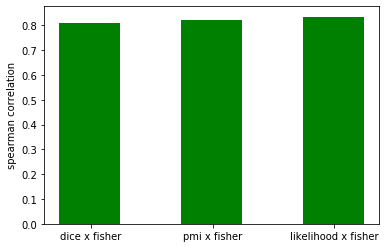

In [36]:
fig, ax = plt.subplots()
rects = ax.bar(range(3), [dice_x_fisher, pmi_x_fisher, likelihood_x_fisher], 0.5, color='g')
ax.set_ylabel('spearman correlation')
ax.set_xticks(np.add(range(3), 1/100))
ax.set_xticklabels(('dice x fisher', 'pmi x fisher', 'likelihood x fisher'))
plt.show()

Наиболее скоррелирована с метрикой фишера, которую мы считаем образцовой, likelihood метрика.

In [0]:
x = np.arange(len(golden_standard))
def draw_graph(values, labels, second_label, ylabel='rank', title=None):
    fig = plt.figure(figsize=(14, 7))
    plt.scatter(x, x, color='r', s=1)
    plt.scatter(x, values, color='g', s=1)
    plt.xticks(x, labels, rotation=-90)
    plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)
    plt.legend(['fisher ranking', second_label])
    plt.show()

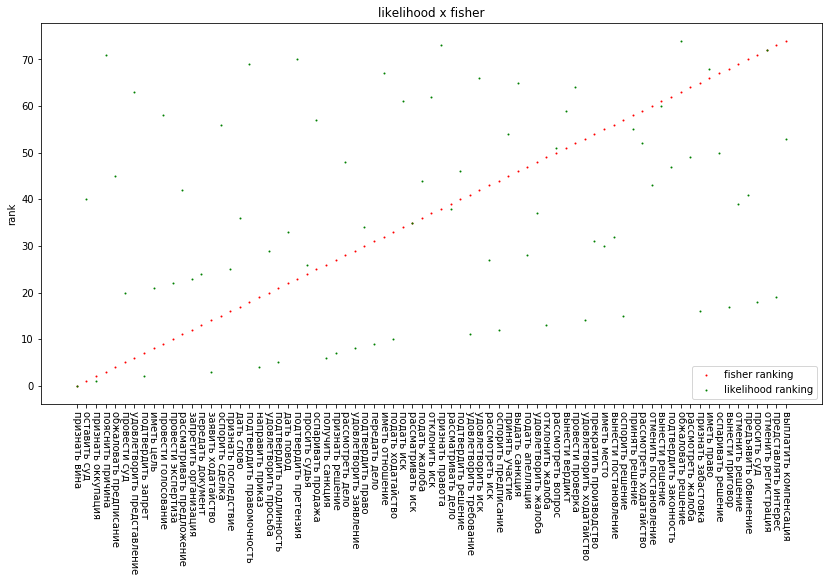

In [38]:
draw_graph(
    [likelihood_sorted.index(elem) for elem in golden_standard],
    [' '.join(elem[0]) for elem in list(ranks_from_sequence(fisher_sorted))],
    'likelihood ranking',
    title='likelihood x fisher'
)

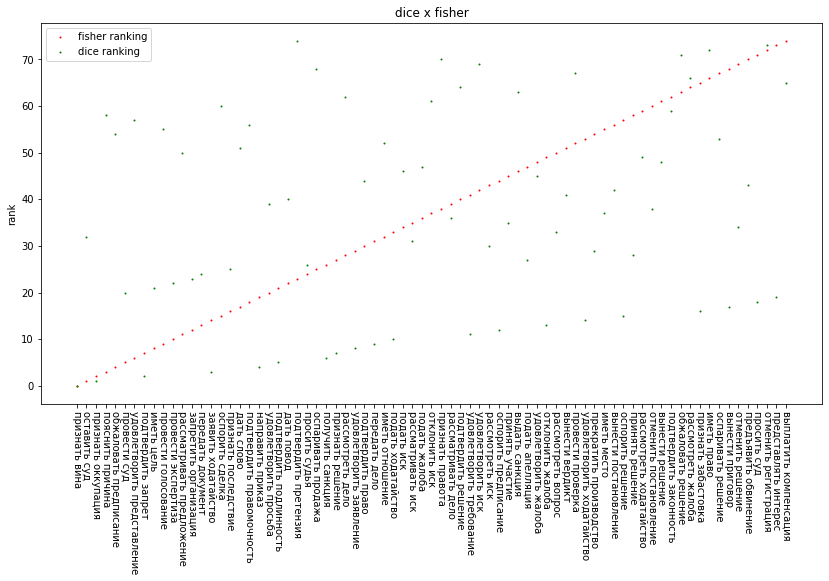

In [39]:
draw_graph(
    [dice_sorted.index(elem) for elem in golden_standard],
    [' '.join(elem[0]) for elem in list(ranks_from_sequence(fisher_sorted))],
    'dice ranking',
    title='dice x fisher'
)

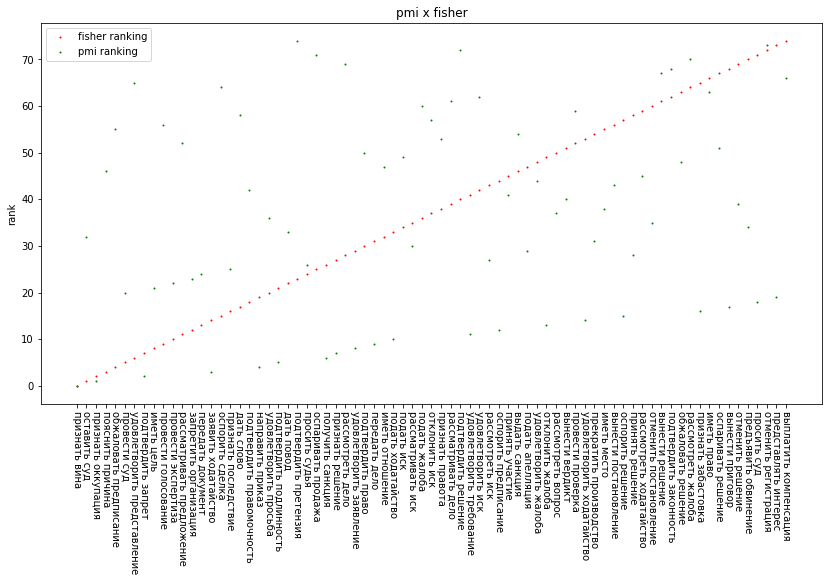

In [40]:
draw_graph(
    [pmi_sorted.index(elem) for elem in golden_standard],
    [' '.join(elem[0]) for elem in list(ranks_from_sequence(fisher_sorted))],
    'pmi ranking',
    title='pmi x fisher'
)

Likelihood, dice и pmi похожи между собой, но не очень похожи на fisher, хотя у всех корреляция положительная и близка к единице (> 0.8). В полном смысле считать ошибками метрик, на мой взгляд, не стоит. Разве что стоит считать ошибкой трёх метрик то, что такие специфичные для корпуса коллокации, как "подтвердить претензия", оцениваются высоко, тогда как fisher оценивает ниже и это выглядит правильным.